In [1]:
import numpy as np
import matplotlib.pyplot as plt
import plotly as plty
import matplotlib.ticker as mtick
import seaborn as sns
%matplotlib inline
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
from sklearn.svm import SVC
warnings.filterwarnings("ignore")
from sklearn import metrics,linear_model
from sklearn.tree import DecisionTreeClassifier
from io import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz

from sklearn.metrics import classification_report,plot_confusion_matrix,accuracy_score,mean_squared_error

In [2]:
path="Customer Churn Data.xlsx"
names = ['AccountID', 'Churn', 'Tenure', 'City_Tier', 'CC_Contacted_LY', 'Payment', 'Gender', 'Service_Score', 'Account_user_count','account_segment','CC_Agent_Score','Marital_Status','rev_per_month','Complain_ly','rev_growth_yoy','coupon_used_for_payment','Day_Since_CC_connect','cashback','Login_device']
df = pd.read_excel(path, names = names,sheet_name='Data for DSBA')
df.head()

,AccountID,Churn,Tenure,City_Tier,CC_Contacted_LY,Payment,Gender,Service_Score,Account_user_count,account_segment,CC_Agent_Score,Marital_Status,rev_per_month,Complain_ly,rev_growth_yoy,coupon_used_for_payment,Day_Since_CC_connect,cashback,Login_device
0,20000,1,4,3.0,6.0,Debit Card,Female,3.0,3,Super,2.0,Single,9,1.0,11,1,5,159.93,Mobile
1,20001,1,0,1.0,8.0,UPI,Male,3.0,4,Regular Plus,3.0,Single,7,1.0,15,0,0,120.9,Mobile
2,20002,1,0,1.0,30.0,Debit Card,Male,2.0,4,Regular Plus,3.0,Single,6,1.0,14,0,3,NaN,Mobile
3,20003,1,0,3.0,15.0,Debit Card,Male,2.0,4,Super,5.0,Single,8,0.0,23,0,3,134.07,Mobile
4,20004,1,0,1.0,12.0,Credit Card,Male,2.0,3,Regular Plus,5.0,Single,3,0.0,11,1,3,129.6,Mobile


In [3]:
df.isna().sum()

AccountID                    0
Churn                        0
Tenure                     102
City_Tier                  112
CC_Contacted_LY            102
Payment                    109
Gender                     108
Service_Score               98
Account_user_count         112
account_segment             97
CC_Agent_Score             116
Marital_Status             212
rev_per_month              102
Complain_ly                357
rev_growth_yoy               0
coupon_used_for_payment      0
Day_Since_CC_connect       357
cashback                   471
Login_device               221
dtype: int64

In [4]:
df.account_segment.value_counts()

Super           4062
Regular Plus    3862
HNI             1639
Super Plus       771
Regular          520
Regular +        262
Super +           47
Name: account_segment, dtype: int64

In [5]:
df['account_segment']=df['account_segment'].replace('Regular +','Regular Plus')
df['account_segment']=df['account_segment'].replace('Super +','Super Plus')
df.account_segment.value_counts()

Regular Plus    4124
Super           4062
HNI             1639
Super Plus       818
Regular          520
Name: account_segment, dtype: int64

<AxesSubplot:xlabel='Churn', ylabel='count'>

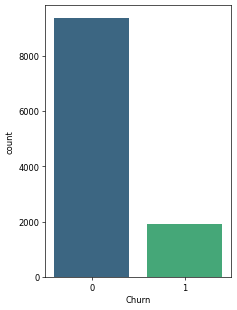

In [6]:
plt.figure(figsize=(4,6),dpi=60)
sns.countplot(data=df,x='Churn',palette='viridis')

In [7]:
df.Gender.value_counts()

Male      6328
Female    4178
M          376
F          270
Name: Gender, dtype: int64

In [8]:
df['Gender']=df['Gender'].replace('M','Male')
df['Gender']=df['Gender'].replace('F','Female')

In [9]:
df.head()

,AccountID,Churn,Tenure,City_Tier,CC_Contacted_LY,Payment,Gender,Service_Score,Account_user_count,account_segment,CC_Agent_Score,Marital_Status,rev_per_month,Complain_ly,rev_growth_yoy,coupon_used_for_payment,Day_Since_CC_connect,cashback,Login_device
0,20000,1,4,3.0,6.0,Debit Card,Female,3.0,3,Super,2.0,Single,9,1.0,11,1,5,159.93,Mobile
1,20001,1,0,1.0,8.0,UPI,Male,3.0,4,Regular Plus,3.0,Single,7,1.0,15,0,0,120.9,Mobile
2,20002,1,0,1.0,30.0,Debit Card,Male,2.0,4,Regular Plus,3.0,Single,6,1.0,14,0,3,NaN,Mobile
3,20003,1,0,3.0,15.0,Debit Card,Male,2.0,4,Super,5.0,Single,8,0.0,23,0,3,134.07,Mobile
4,20004,1,0,1.0,12.0,Credit Card,Male,2.0,3,Regular Plus,5.0,Single,3,0.0,11,1,3,129.6,Mobile


In [10]:
df['rev_per_month'].count()

11158

In [11]:
columns = df.columns
binary_cols = []
for col in columns:
    if df[col].value_counts().shape[0] ==2:
        binary_cols.append(col)

In [12]:
binary_cols

['Churn', 'Gender', 'Complain_ly']

In [13]:
df.dtypes

AccountID                    int64
Churn                        int64
Tenure                      object
City_Tier                  float64
CC_Contacted_LY            float64
Payment                     object
Gender                      object
Service_Score              float64
Account_user_count          object
account_segment             object
CC_Agent_Score             float64
Marital_Status              object
rev_per_month               object
Complain_ly                float64
rev_growth_yoy              object
coupon_used_for_payment     object
Day_Since_CC_connect        object
cashback                    object
Login_device                object
dtype: object

## Cleaning the dataset

In [14]:
df['rev_per_month']=df['rev_per_month'].replace('+','')
df['rev_per_month']=pd.to_numeric(df['rev_per_month'])
df['rev_per_month']=df['rev_per_month'].replace('',df['rev_per_month'].mean())

In [15]:
df['Tenure']=df['Tenure'].replace('#','')
df['Tenure']=pd.to_numeric(df['Tenure'])
df['Tenure']=df['Tenure'].replace('',df['Tenure'].mean())

In [16]:
df['Day_Since_CC_connect']=df['Day_Since_CC_connect'].replace('$','')
df['Day_Since_CC_connect']=pd.to_numeric(df['Day_Since_CC_connect'])
df['Day_Since_CC_connect']=df['Day_Since_CC_connect'].replace('',df['Day_Since_CC_connect'].mean())

In [17]:
df['Account_user_count']=df['Account_user_count'].replace('@','')
df['Account_user_count']=pd.to_numeric(df['Account_user_count'])
df['Account_user_count']=df['Account_user_count'].replace('',df['Account_user_count'].mean())

In [18]:
df['rev_growth_yoy']=df['rev_growth_yoy'].replace('$','')
df['rev_growth_yoy']=pd.to_numeric(df['rev_growth_yoy'])
df['rev_growth_yoy']=df['rev_growth_yoy'].replace('',df['rev_growth_yoy'].mean())

In [19]:
df['cashback']=df['cashback'].replace('$','')
df['cashback']=pd.to_numeric(df['cashback'])
df['cashback']=df['cashback'].replace('',df['cashback'].mean())

In [20]:
df['Login_device']=df['Login_device'].replace('&&&&','Tab')
df['Login_device']=df['Login_device'].replace('','Tab')

In [21]:
df['coupon_used_for_payment']=df['coupon_used_for_payment'].replace('$','')
df['coupon_used_for_payment']=df['coupon_used_for_payment'].replace('#','')
df['coupon_used_for_payment']=df['coupon_used_for_payment'].replace('*','')
df['coupon_used_for_payment']=pd.to_numeric(df['coupon_used_for_payment'])
df['coupon_used_for_payment']=df['coupon_used_for_payment'].replace('',df['coupon_used_for_payment'].mean())

In [22]:
df.dtypes

AccountID                    int64
Churn                        int64
Tenure                     float64
City_Tier                  float64
CC_Contacted_LY            float64
Payment                     object
Gender                      object
Service_Score              float64
Account_user_count         float64
account_segment             object
CC_Agent_Score             float64
Marital_Status              object
rev_per_month              float64
Complain_ly                float64
rev_growth_yoy             float64
coupon_used_for_payment    float64
Day_Since_CC_connect       float64
cashback                   float64
Login_device                object
dtype: object

[Text(0, 0, '1.0'), Text(1, 0, '2.0'), Text(2, 0, '3.0')]

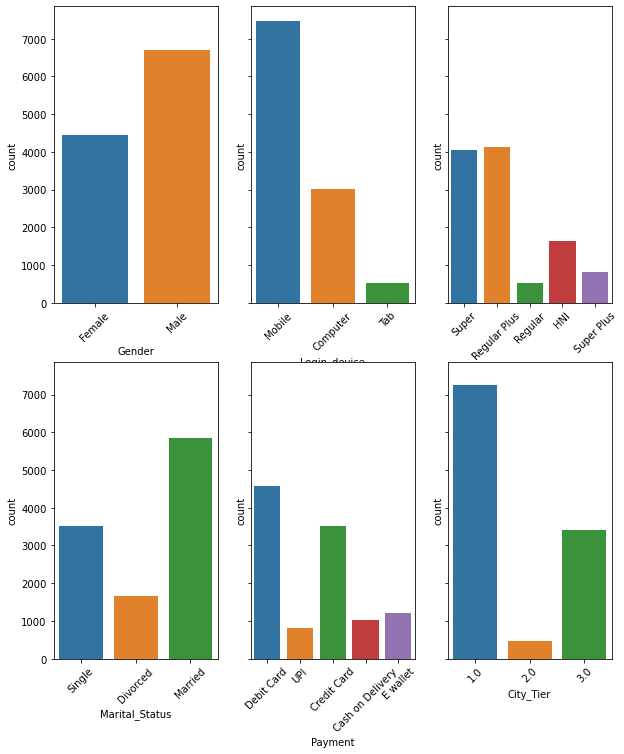

In [23]:
#distribution of the dataset

fig, axes = plt.subplots(2, 3, figsize=(10, 12), sharey=True)
a=sns.countplot("Gender", data=df, ax=axes[0,0])
b=sns.countplot("Login_device", data=df, ax=axes[0,1])
c=sns.countplot("account_segment", data=df, ax=axes[0,2])
d=sns.countplot("Marital_Status", data=df, ax=axes[1,0])
e=sns.countplot("Payment", data=df, ax=axes[1,1])
f=sns.countplot("City_Tier", data=df, ax=axes[1,2])
a.set_xticklabels(a.get_xticklabels(), rotation=45)
b.set_xticklabels(b.get_xticklabels(), rotation=45)
c.set_xticklabels(c.get_xticklabels(), rotation=45)
d.set_xticklabels(d.get_xticklabels(), rotation=45)
e.set_xticklabels(e.get_xticklabels(), rotation=45)
f.set_xticklabels(f.get_xticklabels(), rotation=45)


In [24]:
df[['Gender','Churn']].groupby(['Gender']).mean()

,Churn
Gender,
Female,0.154901
Male,0.176760


In [25]:
correlations = df.corr()

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11260 entries, 0 to 11259
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   AccountID                11260 non-null  int64  
 1   Churn                    11260 non-null  int64  
 2   Tenure                   11042 non-null  float64
 3   City_Tier                11148 non-null  float64
 4   CC_Contacted_LY          11158 non-null  float64
 5   Payment                  11151 non-null  object 
 6   Gender                   11152 non-null  object 
 7   Service_Score            11162 non-null  float64
 8   Account_user_count       10816 non-null  float64
 9   account_segment          11163 non-null  object 
 10  CC_Agent_Score           11144 non-null  float64
 11  Marital_Status           11048 non-null  object 
 12  rev_per_month            10469 non-null  float64
 13  Complain_ly              10903 non-null  float64
 14  rev_growth_yoy        

In [27]:
df.isna().sum()

AccountID                    0
Churn                        0
Tenure                     218
City_Tier                  112
CC_Contacted_LY            102
Payment                    109
Gender                     108
Service_Score               98
Account_user_count         444
account_segment             97
CC_Agent_Score             116
Marital_Status             212
rev_per_month              791
Complain_ly                357
rev_growth_yoy               3
coupon_used_for_payment      3
Day_Since_CC_connect       358
cashback                   473
Login_device               221
dtype: int64

In [28]:
df.drop_duplicates(keep=False, inplace=True)

<AxesSubplot:xlabel='Churn', ylabel='count'>

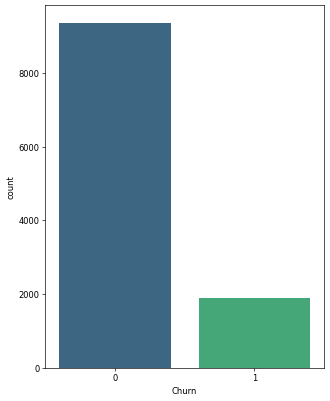

In [29]:
plt.figure(figsize=(6,8),dpi=60)
sns.countplot(data=df,x='Churn',palette='viridis')

In [30]:
df.shape

(11260, 19)

<AxesSubplot:>

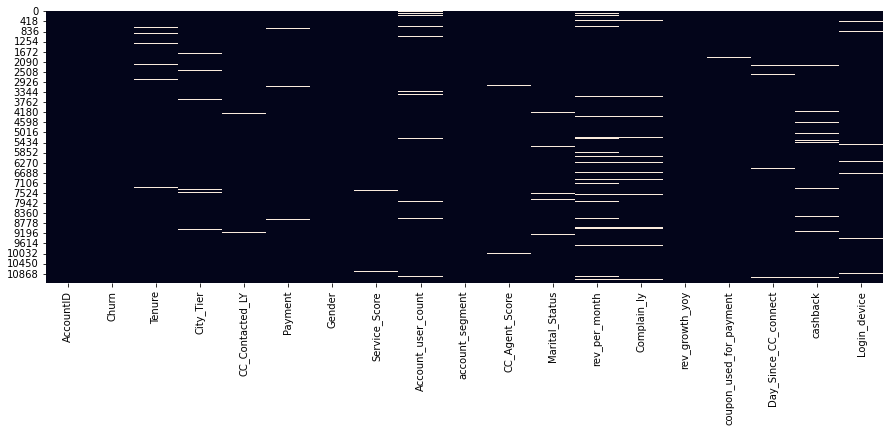

In [31]:
#dsitribution of the null values in the dataset
plt.figure(figsize=(15,5))
sns.heatmap(df.isna(),cbar=False)

In [32]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [33]:
#checking the null values in all the columns
na_cols = df.isna().any()
print(na_cols)

AccountID                  False
Churn                      False
Tenure                      True
City_Tier                   True
CC_Contacted_LY             True
Payment                     True
Gender                      True
Service_Score               True
Account_user_count          True
account_segment             True
CC_Agent_Score              True
Marital_Status              True
rev_per_month               True
Complain_ly                 True
rev_growth_yoy              True
coupon_used_for_payment     True
Day_Since_CC_connect        True
cashback                    True
Login_device                True
dtype: bool


In [34]:
#Missing Values Treatment for Non Categorical Values
na_cols = na_cols[na_cols == True].reset_index()
na_cols = na_cols["index"].tolist()
for col in df.columns[1:]:
     if col in na_cols:
            
            if df[col].dtype != 'object':
                 df[col] =  df[col].fillna(df[col].mean()).round(0)            

In [35]:
df.isna().sum()

AccountID                    0
Churn                        0
Tenure                       0
City_Tier                    0
CC_Contacted_LY              0
Payment                    109
Gender                     108
Service_Score                0
Account_user_count           0
account_segment             97
CC_Agent_Score               0
Marital_Status             212
rev_per_month                0
Complain_ly                  0
rev_growth_yoy               0
coupon_used_for_payment      0
Day_Since_CC_connect         0
cashback                     0
Login_device               221
dtype: int64

In [36]:
df['Payment']=df['Payment'].fillna(df['Payment'].mode())

In [37]:
df.isna().sum()

AccountID                    0
Churn                        0
Tenure                       0
City_Tier                    0
CC_Contacted_LY              0
Payment                    109
Gender                     108
Service_Score                0
Account_user_count           0
account_segment             97
CC_Agent_Score               0
Marital_Status             212
rev_per_month                0
Complain_ly                  0
rev_growth_yoy               0
coupon_used_for_payment      0
Day_Since_CC_connect         0
cashback                     0
Login_device               221
dtype: int64

In [38]:
df['Login_device']=df['Login_device'].fillna("Mobile")

In [39]:
df.isna().sum()

AccountID                    0
Churn                        0
Tenure                       0
City_Tier                    0
CC_Contacted_LY              0
Payment                    109
Gender                     108
Service_Score                0
Account_user_count           0
account_segment             97
CC_Agent_Score               0
Marital_Status             212
rev_per_month                0
Complain_ly                  0
rev_growth_yoy               0
coupon_used_for_payment      0
Day_Since_CC_connect         0
cashback                     0
Login_device                 0
dtype: int64

In [40]:
value=df.values
print(value)

[[20000 1 4.0 ... 5.0 160.0 'Mobile']
 [20001 1 0.0 ... 0.0 121.0 'Mobile']
 [20002 1 0.0 ... 3.0 196.0 'Mobile']
 ...
 [31257 0 1.0 ... 4.0 191.0 'Mobile']
 [31258 0 23.0 ... 9.0 180.0 'Computer']
 [31259 0 8.0 ... 3.0 175.0 'Mobile']]


In [41]:
from sklearn.impute import SimpleImputer
from numpy import isnan
imputer = SimpleImputer(missing_values=np.nan,strategy='most_frequent')

 
# transform the dataset
transformed_values = imputer.fit_transform(value)

In [42]:
#missing values treatment for categorical Values
df['Payment'].fillna(df['Payment'].mode()[0], inplace=True)
df['Gender'].fillna(df['Gender'].mode()[0], inplace=True)
df['account_segment'].fillna(df['account_segment'].mode()[0], inplace=True)
df['Marital_Status'].fillna(df['Marital_Status'].mode()[0], inplace=True)


In [43]:
df.isna().sum()

AccountID                  0
Churn                      0
Tenure                     0
City_Tier                  0
CC_Contacted_LY            0
Payment                    0
Gender                     0
Service_Score              0
Account_user_count         0
account_segment            0
CC_Agent_Score             0
Marital_Status             0
rev_per_month              0
Complain_ly                0
rev_growth_yoy             0
coupon_used_for_payment    0
Day_Since_CC_connect       0
cashback                   0
Login_device               0
dtype: int64

In [44]:
df.dtypes

AccountID                    int64
Churn                        int64
Tenure                     float64
City_Tier                  float64
CC_Contacted_LY            float64
Payment                     object
Gender                      object
Service_Score              float64
Account_user_count         float64
account_segment             object
CC_Agent_Score             float64
Marital_Status              object
rev_per_month              float64
Complain_ly                float64
rev_growth_yoy             float64
coupon_used_for_payment    float64
Day_Since_CC_connect       float64
cashback                   float64
Login_device                object
dtype: object

In [45]:
df.head()

,AccountID,Churn,Tenure,City_Tier,CC_Contacted_LY,Payment,Gender,Service_Score,Account_user_count,account_segment,CC_Agent_Score,Marital_Status,rev_per_month,Complain_ly,rev_growth_yoy,coupon_used_for_payment,Day_Since_CC_connect,cashback,Login_device
0,20000,1,4.0,3.0,6.0,Debit Card,Female,3.0,3.0,Super,2.0,Single,9.0,1.0,11.0,1.0,5.0,160.0,Mobile
1,20001,1,0.0,1.0,8.0,UPI,Male,3.0,4.0,Regular Plus,3.0,Single,7.0,1.0,15.0,0.0,0.0,121.0,Mobile
2,20002,1,0.0,1.0,30.0,Debit Card,Male,2.0,4.0,Regular Plus,3.0,Single,6.0,1.0,14.0,0.0,3.0,196.0,Mobile
3,20003,1,0.0,3.0,15.0,Debit Card,Male,2.0,4.0,Super,5.0,Single,8.0,0.0,23.0,0.0,3.0,134.0,Mobile
4,20004,1,0.0,1.0,12.0,Credit Card,Male,2.0,3.0,Regular Plus,5.0,Single,3.0,0.0,11.0,1.0,3.0,130.0,Mobile


In [46]:
contract_split = df[[ "AccountID", "Payment"]]
sectors = contract_split .groupby ("Payment")
contract_split = pd.DataFrame(sectors["AccountID"].count())
contract_split.rename(columns={'AccountID':'No. of customers'}, inplace=True)

(array([   0., 1000., 2000., 3000., 4000., 5000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

<Figure size 1080x360 with 0 Axes>

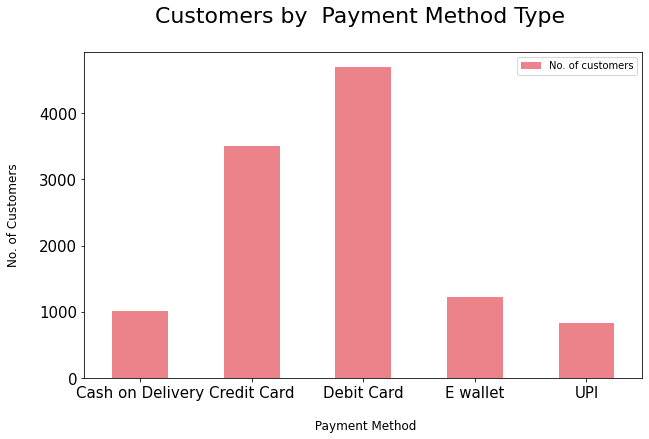

In [47]:
plt.figure(figsize=(15,5))
ax =  contract_split[["No. of customers"]].plot.bar(title = 'Customers by Payment Method',legend =True, table = False, 
grid = False,  subplots = False,figsize =(10, 6), color ='#ec838a', 
fontsize = 15, stacked=False)
plt.ylabel('No. of Customers\n',
horizontalalignment="center",fontstyle = "normal", 
fontsize = "large", fontfamily = "sans-serif")
plt.xlabel('\n Payment Method',
horizontalalignment="center",fontstyle = "normal", 
fontsize = "large", fontfamily = "sans-serif")
plt.title('Customers by  Payment Method Type \n',
horizontalalignment="center",fontstyle = "normal", 
fontsize = "22", fontfamily = "sans-serif")
plt.legend(loc='upper right', fontsize = "medium")
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")

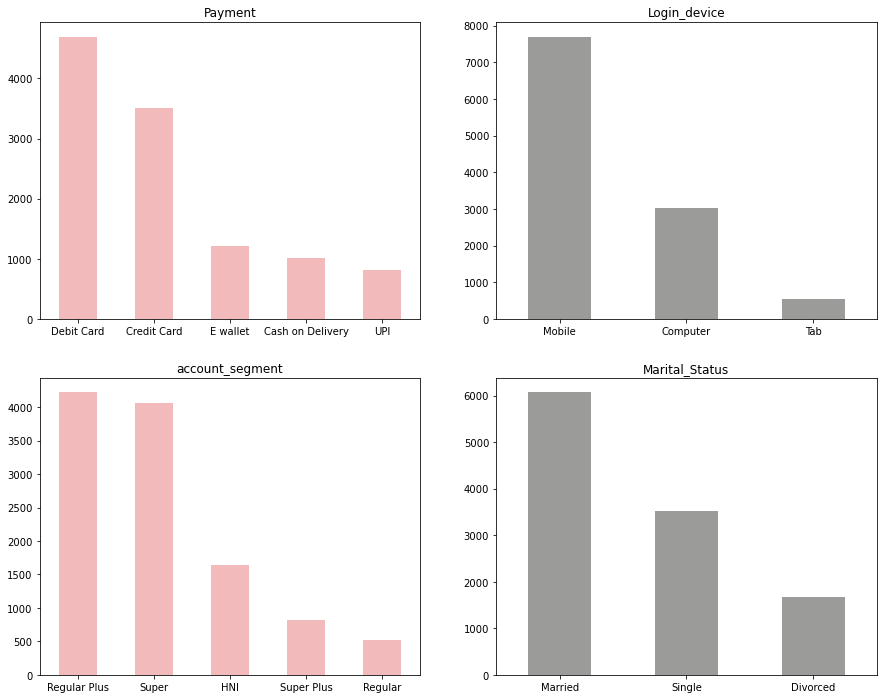

In [48]:
services= ['Payment','account_segment',
'Marital_Status','Login_device']
fig, axes = plt.subplots(nrows = 2,ncols = 2,
figsize = (15,12))
for i, item in enumerate(services):
    if i < 2:
        ax = df[item].value_counts().plot(kind = 'bar',ax=axes[i,0],rot = 0, color ='#f3babc' )
        ax.set_title(item)
        
    elif i >=2 and i < 4:
        ax = df[item].value_counts().plot(kind = 'bar',ax=axes[i-3,1],rot = 0,color ='#9b9c9a')
        ax.set_title(item)

<Figure size 1080x360 with 0 Axes>

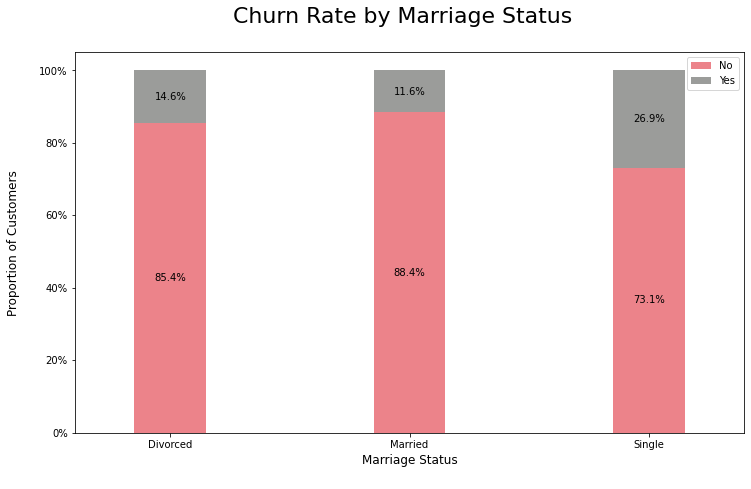

In [49]:
import matplotlib.ticker as mtick
plt.figure(figsize=(15,5))
contract_churn =df.groupby(['Marital_Status','Churn']).size().unstack()
contract_churn.rename(columns={0:'No', 1:'Yes'}, inplace=True)
colors  = ['#ec838a','#9b9c9a']
ax = (contract_churn.T*100.0 / contract_churn.T.sum()).T.plot(kind='bar',width = 0.3,stacked = True,rot = 0,figsize = (12,7),color = colors)
plt.ylabel('Proportion of Customers\n',
horizontalalignment="center",fontstyle = "normal", 
fontsize = "large", fontfamily = "sans-serif")
plt.xlabel('Marriage Status\n',horizontalalignment="center",
fontstyle = "normal", fontsize = "large", 
fontfamily = "sans-serif")
plt.title('Churn Rate by Marriage Status  \n',
horizontalalignment="center", fontstyle = "normal", 
fontsize = "22", fontfamily = "sans-serif")
plt.legend(loc='upper right', fontsize = "medium")
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x+width/2, 
            y+height/2, 
            '{:.1f}%'.format(height), 
            horizontalalignment='center', 
            verticalalignment='center')
ax.autoscale(enable=False, axis='both', tight=False)


<Figure size 1080x360 with 0 Axes>

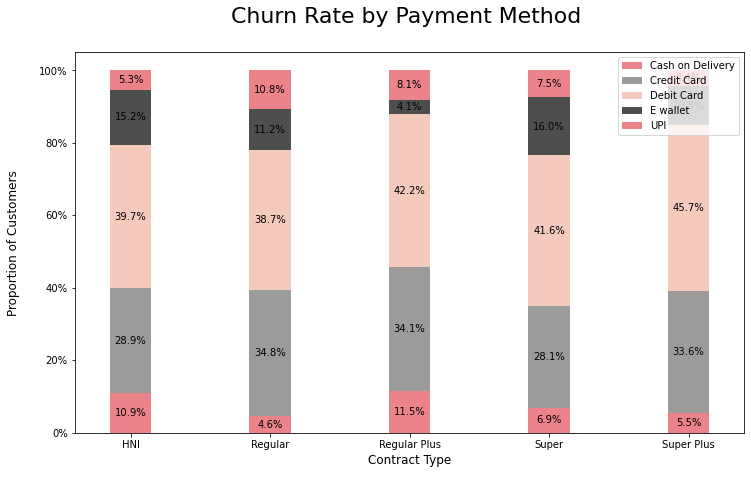

In [50]:

plt.figure(figsize=(15,5))
segment_churn = df.groupby(['account_segment','Payment']).size().unstack()
segment_churn.rename(columns={0:'No', 1:'Yes'}, inplace=True)
colors  = ['#ec838b','#9b9c9a', '#f3cabc' , '#4d4f4c']
ax = (segment_churn.T*100.0 / segment_churn.T.sum()).T.plot(kind='bar',width = 0.3,stacked = True,rot = 0,figsize = (12,7),color = colors)
plt.ylabel('Proportion of Customers\n',
horizontalalignment="center",fontstyle = "normal", 
fontsize = "large", fontfamily = "sans-serif")
plt.xlabel('Contract Type\n',horizontalalignment="center",fontstyle = "normal", fontsize = "large", fontfamily = "sans-serif")
plt.title('Churn Rate by Payment Method \n',horizontalalignment="center", fontstyle = "normal", fontsize = "22", fontfamily = "sans-serif")
plt.legend(loc='upper right', fontsize = "medium")
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x+width/2, 
            y+height/2, 
            '{:.1f}%'.format(height), 
            horizontalalignment='center', 
            verticalalignment='center')
ax.autoscale(enable=False, axis='both', tight=False)


In [51]:
dataset2 = df[['Payment','account_segment','Marital_Status','Login_device']]
dataset2.head()

,Payment,account_segment,Marital_Status,Login_device
0,Debit Card,Super,Single,Mobile
1,UPI,Regular Plus,Single,Mobile
2,Debit Card,Regular Plus,Single,Mobile
3,Debit Card,Super,Single,Mobile
4,Credit Card,Regular Plus,Single,Mobile


In [52]:
correlations = df.corr()['Churn'].sort_values(ascending = False)
for i in correlations:
    print(i)

1.0
0.24635002235367898
0.10516514573086404
0.10453363862808077
0.08352172721244512
0.07173463778259558
0.021882320010373057
0.008935889933337287
-0.009541386555324641
-0.013870049488837405
-0.014838399408950705
-0.0316573039176082
-0.145355904311918
-0.23032682555327275


Text(0.5, 0, 'Login Device')

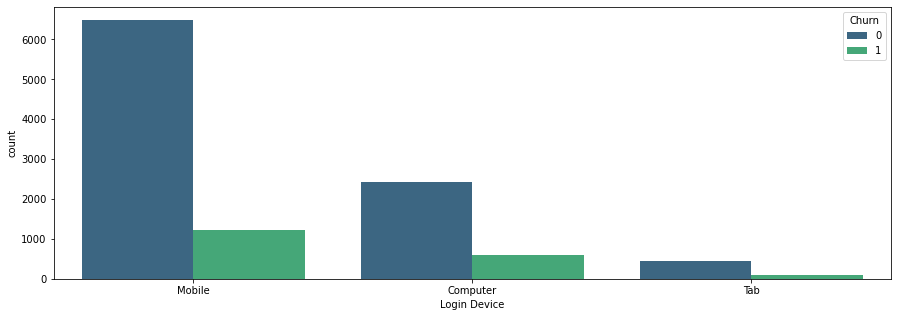

In [53]:
plt.figure(figsize=(15,5))
sns.countplot(data=df,x='Login_device',hue='Churn',palette='viridis')
plt.xlabel('Login Device')

In [54]:
df.head()

,AccountID,Churn,Tenure,City_Tier,CC_Contacted_LY,Payment,Gender,Service_Score,Account_user_count,account_segment,CC_Agent_Score,Marital_Status,rev_per_month,Complain_ly,rev_growth_yoy,coupon_used_for_payment,Day_Since_CC_connect,cashback,Login_device
0,20000,1,4.0,3.0,6.0,Debit Card,Female,3.0,3.0,Super,2.0,Single,9.0,1.0,11.0,1.0,5.0,160.0,Mobile
1,20001,1,0.0,1.0,8.0,UPI,Male,3.0,4.0,Regular Plus,3.0,Single,7.0,1.0,15.0,0.0,0.0,121.0,Mobile
2,20002,1,0.0,1.0,30.0,Debit Card,Male,2.0,4.0,Regular Plus,3.0,Single,6.0,1.0,14.0,0.0,3.0,196.0,Mobile
3,20003,1,0.0,3.0,15.0,Debit Card,Male,2.0,4.0,Super,5.0,Single,8.0,0.0,23.0,0.0,3.0,134.0,Mobile
4,20004,1,0.0,1.0,12.0,Credit Card,Male,2.0,3.0,Regular Plus,5.0,Single,3.0,0.0,11.0,1.0,3.0,130.0,Mobile


## All Variables with churn

Text(0.5, 0, 'User Per Account')

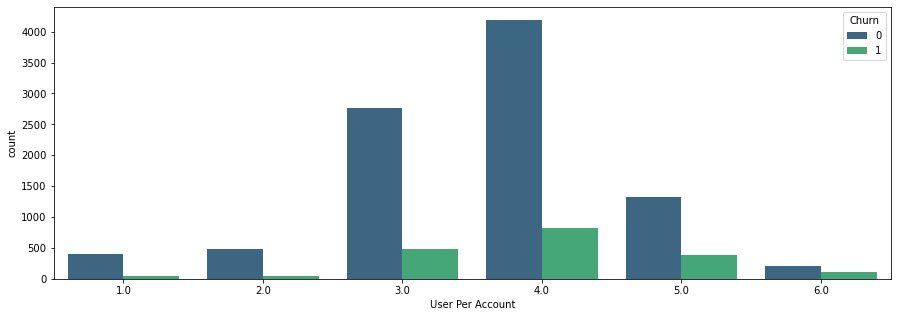

In [55]:
plt.figure(figsize=(15,5))
sns.countplot(data=df,x='Account_user_count',hue='Churn',palette='viridis')
plt.xlabel('User Per Account')


Text(0.5, 0, 'Payment')

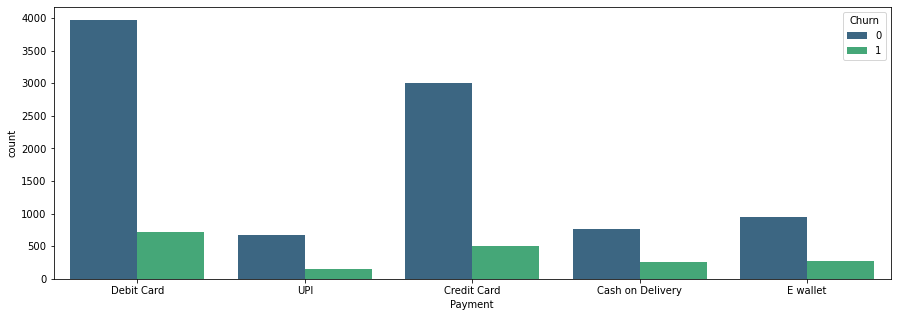

In [56]:
plt.figure(figsize=(15,5))
sns.countplot(data=df,x='Payment',hue='Churn',palette='viridis')
plt.xlabel('Payment')

Text(0.5, 0, 'Service Score')

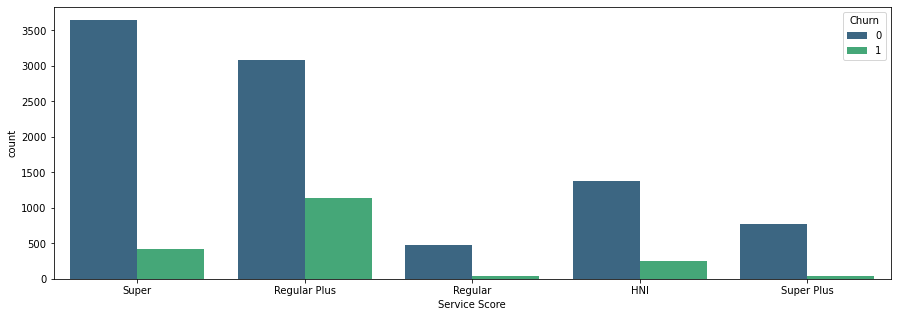

In [57]:
plt.figure(figsize=(15,5))
sns.countplot(data=df,x='account_segment',hue='Churn',palette='viridis')
plt.xlabel('Service Score')

<AxesSubplot:>

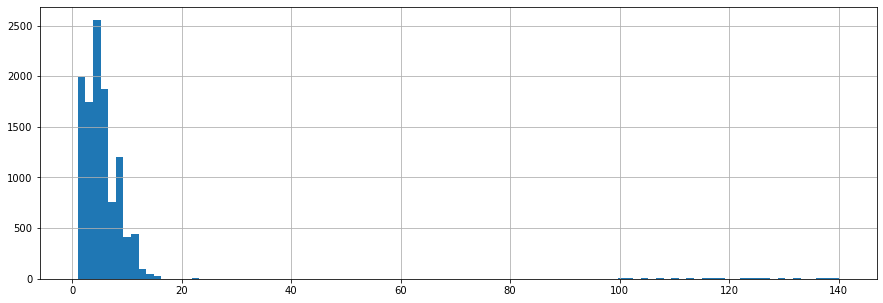

In [58]:
plt.figure(figsize=(15,5))
df['rev_per_month'].hist(bins=100)

In [59]:
df.columns

Index(['AccountID', 'Churn', 'Tenure', 'City_Tier', 'CC_Contacted_LY',
       'Payment', 'Gender', 'Service_Score', 'Account_user_count',
       'account_segment', 'CC_Agent_Score', 'Marital_Status', 'rev_per_month',
       'Complain_ly', 'rev_growth_yoy', 'coupon_used_for_payment',
       'Day_Since_CC_connect', 'cashback', 'Login_device'],
      dtype='object')

<Figure size 360x360 with 0 Axes>

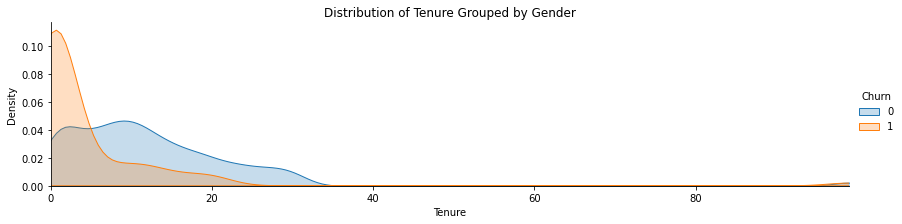

<Figure size 360x360 with 0 Axes>

In [60]:
fig = sns.FacetGrid(df, hue='Churn', aspect=4)
fig.map(sns.kdeplot, 'Tenure', shade=True)
oldest = df['Tenure'].max()
fig.set(xlim=(0,oldest))
fig.set(title='Distribution of Tenure Grouped by Gender')
fig.add_legend()
plt.figure(figsize=(5,5))

<Figure size 1080x360 with 0 Axes>

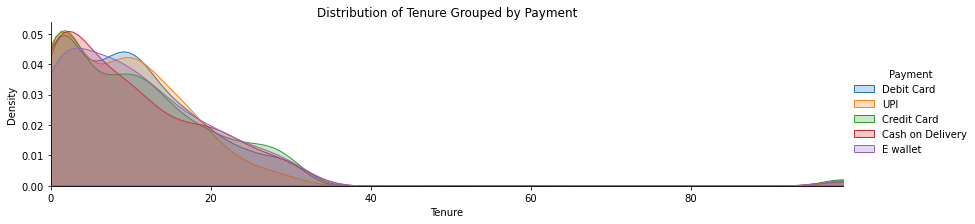

In [61]:
plt.figure(figsize=(15,5))
fig = sns.FacetGrid(df, hue='Payment', aspect=4)
fig.map(sns.kdeplot, 'Tenure', shade=True)
oldest = df['Tenure'].max()
fig.set(xlim=(0,oldest))
fig.set(title='Distribution of Tenure Grouped by Payment')
fig.add_legend()

<Figure size 1080x360 with 0 Axes>

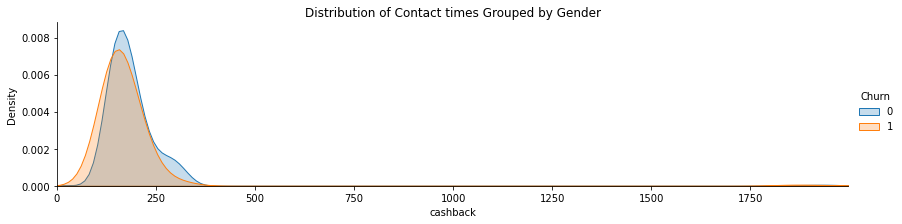

In [62]:
plt.figure(figsize=(15,5))
fig = sns.FacetGrid(df, hue='Churn', aspect=4)
fig.map(sns.kdeplot, 'cashback', shade=True)
oldest = df['cashback'].max()
fig.set(xlim=(0,oldest))
fig.set(title='Distribution of Contact times Grouped by Gender')
fig.add_legend()

<Figure size 1080x360 with 0 Axes>

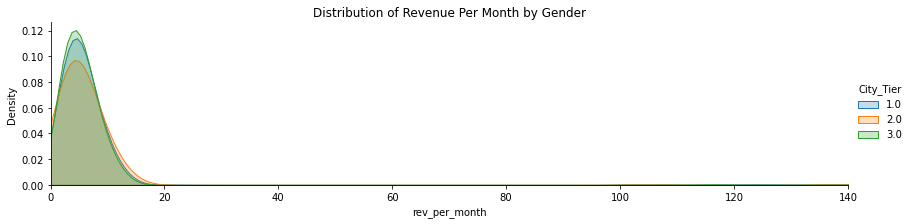

In [63]:
plt.figure(figsize=(15,5))
fig = sns.FacetGrid(df, hue='City_Tier', aspect=4)
fig.map(sns.kdeplot, 'rev_per_month', shade=True)
oldest = df['rev_per_month'].max()
fig.set(xlim=(0,oldest))
fig.set(title='Distribution of Revenue Per Month by Gender')
fig.add_legend()

<Figure size 1080x360 with 0 Axes>

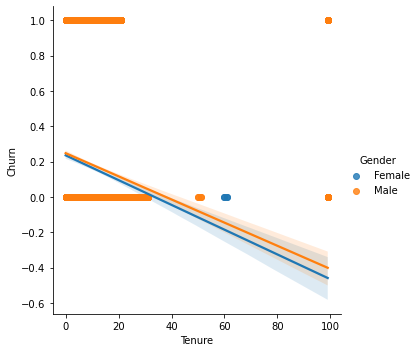

In [64]:
plt.figure(figsize=(15,5))
sns.lmplot('Tenure', 'Churn', data=df,hue='Gender')

<AxesSubplot:xlabel='Tenure', ylabel='Density'>

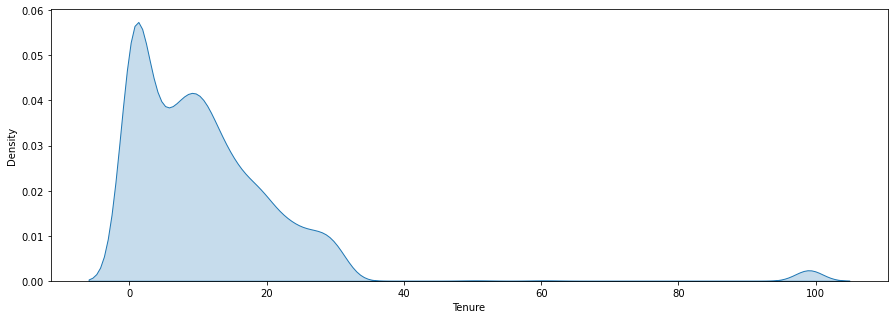

In [65]:
plt.figure(figsize=(15,5))
sns.kdeplot(df['Tenure'],shade=True)

<Figure size 360x360 with 0 Axes>

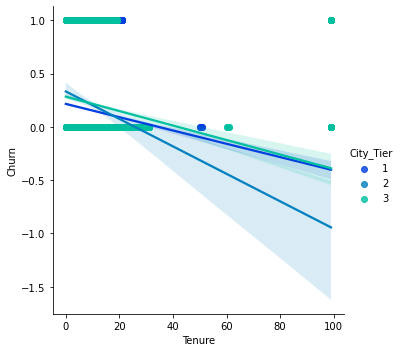

In [66]:
plt.figure(figsize=(5,5))
sns.lmplot('Tenure', 'Churn', hue='City_Tier', data=df, palette='winter', hue_order=range(1,4))


<Figure size 1080x360 with 0 Axes>

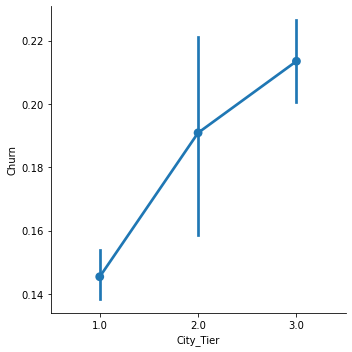

In [67]:
plt.figure(figsize=(15,5))
sns.factorplot('City_Tier', 'Churn', data=df)


Text(0.5, 1.0, 'Correlation with Churn Rate \n')

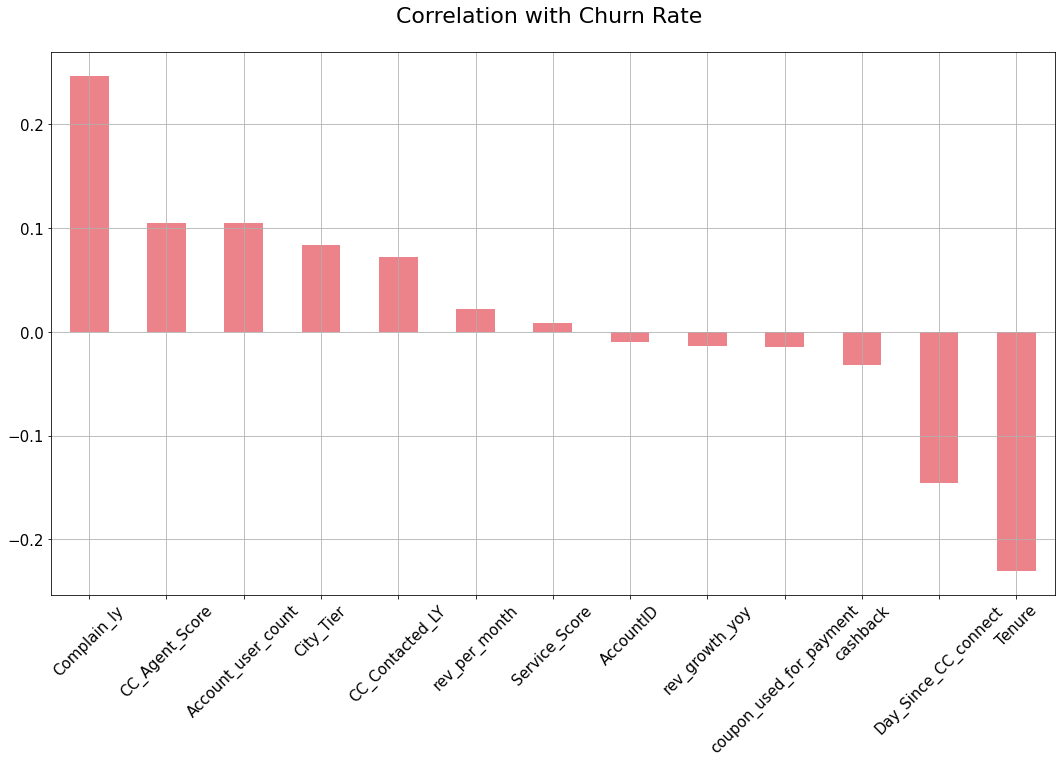

In [68]:
correlations = correlations[correlations!=1]
correlations.plot.bar(
        figsize = (18, 10), 
        fontsize = 15, 
        color = '#ec838a',
        rot = 45, grid = True)
plt.title('Correlation with Churn Rate \n',
horizontalalignment="center", fontstyle = "normal", 
fontsize = "22", fontfamily = "sans-serif")

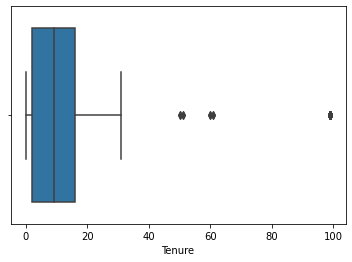

In [69]:
import seaborn as sns
#sns.boxplot(x=boston_df['DIS'])
sns.boxplot(x=df['Tenure'])
 
# show plot
plt.show()


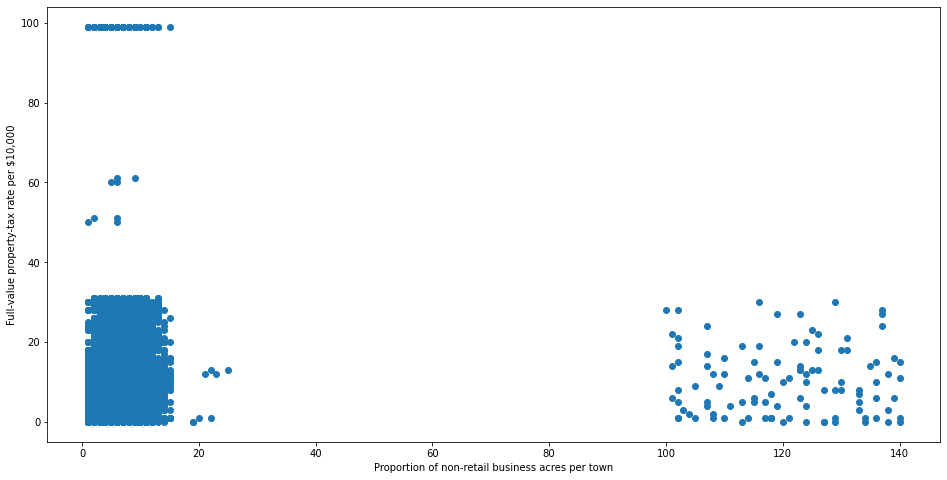

In [70]:
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(df['rev_per_month'], df['Tenure'])
ax.set_xlabel('Proportion of non-retail business acres per town')
ax.set_ylabel('Full-value property-tax rate per $10,000')
plt.show()

In [71]:
df.describe()

,AccountID,Churn,Tenure,City_Tier,CC_Contacted_LY,Service_Score,Account_user_count,CC_Agent_Score,rev_per_month,Complain_ly,rev_growth_yoy,coupon_used_for_payment,Day_Since_CC_connect,cashback
count,11260.00000,11260.000000,11260.000000,11260.000000,11260.000000,11260.000000,11260.000000,11260.000000,11260.000000,11260.000000,11260.000000,11260.000000,11260.000000,11260.000000
mean,25629.50000,0.168384,11.024600,1.657371,17.868295,2.903375,3.704973,3.065808,6.337123,0.276288,16.193339,1.790675,4.644849,196.222114
std,3250.62635,0.374223,12.754482,0.911100,8.813084,0.722476,1.004383,1.372663,11.484085,0.447181,3.757222,1.969291,3.638945,174.864197
min,20000.00000,0.000000,0.000000,1.000000,4.000000,0.000000,1.000000,1.000000,1.000000,0.000000,4.000000,0.000000,0.000000,0.000000
25%,22814.75000,0.000000,2.000000,1.000000,11.000000,2.000000,3.000000,2.000000,3.000000,0.000000,13.000000,1.000000,2.000000,148.000000
50%,25629.50000,0.000000,9.000000,1.000000,16.000000,3.000000,4.000000,3.000000,5.000000,0.000000,15.000000,1.000000,4.000000,167.000000
75%,28444.25000,0.000000,16.000000,3.000000,23.000000,3.000000,4.000000,4.000000,7.000000,1.000000,19.000000,2.000000,7.000000,197.000000
max,31259.00000,1.000000,99.000000,3.000000,132.000000,5.000000,6.000000,5.000000,140.000000,1.000000,28.000000,16.000000,47.000000,1997.000000


In [72]:
# Label Encoding will be used for columns with 5 or less unique 
le = LabelEncoder()
value
le_count = 0
for col in df.columns[1:]:
    if df[col].dtype == 'object':
        if len(list(df[col].unique())) <= 5:
            le.fit(df[col])
            df[col] = le.transform(df[col])
            le_count += 1
print('{} columns were label encoded.'.format(le_count))

5 columns were label encoded.


In [73]:
df.head()

,AccountID,Churn,Tenure,City_Tier,CC_Contacted_LY,Payment,Gender,Service_Score,Account_user_count,account_segment,CC_Agent_Score,Marital_Status,rev_per_month,Complain_ly,rev_growth_yoy,coupon_used_for_payment,Day_Since_CC_connect,cashback,Login_device
0,20000,1,4.0,3.0,6.0,2,0,3.0,3.0,3,2.0,2,9.0,1.0,11.0,1.0,5.0,160.0,1
1,20001,1,0.0,1.0,8.0,4,1,3.0,4.0,2,3.0,2,7.0,1.0,15.0,0.0,0.0,121.0,1
2,20002,1,0.0,1.0,30.0,2,1,2.0,4.0,2,3.0,2,6.0,1.0,14.0,0.0,3.0,196.0,1
3,20003,1,0.0,3.0,15.0,2,1,2.0,4.0,3,5.0,2,8.0,0.0,23.0,0.0,3.0,134.0,1
4,20004,1,0.0,1.0,12.0,1,1,2.0,3.0,2,5.0,2,3.0,0.0,11.0,1.0,3.0,130.0,1


In [74]:
# identify outliers
data_mean, data_std = np.mean(df['Tenure']), np.std(df['Tenure'])
cut_off = data_std * 3
lower, upper = data_mean - cut_off, data_mean + cut_off

In [75]:
outliers = [x for x in df['Tenure'] if x < lower or x > upper]

In [76]:
len(outliers)

139

In [77]:
from scipy import stats
import numpy as np
z = np.abs(stats.zscore(df))
print(z)

       AccountID     Churn    Tenure  City_Tier  CC_Contacted_LY   Payment  \
0       1.731897  2.222345  0.550780   1.473700         1.346727  0.236005   
1       1.731589  2.222345  0.864409   0.721546         1.119782  2.220635   
2       1.731282  2.222345  0.864409   0.721546         1.376617  0.236005   
3       1.730974  2.222345  0.864409   1.473700         0.325473  0.236005   
4       1.730666  2.222345  0.864409   0.721546         0.665891  0.756310   
...          ...       ...       ...        ...              ...       ...   
11255   1.730666  0.449975  0.080336   0.721546         1.830508  0.756310   
11256   1.730974  0.449975  0.154886   0.721546         0.128418  0.756310   
11257   1.731282  0.449975  0.786002   0.721546         0.438946  0.236005   
11258   1.731589  0.449975  0.938959   1.473700         0.779364  0.756310   
11259   1.731897  0.449975  0.237151   0.721546         0.468836  0.756310   

         Gender  Service_Score  Account_user_count  account_seg

In [78]:
threshold = 3
print(np.where(z > 3))

(array([   10,    17,    21,    31,    54,    69,    69,    87,    93,
         119,   126,   150,   189,   191,   201,   205,   226,   234,
         259,   261,   270,   276,   300,   302,   326,   338,   341,
         381,   383,   387,   389,   410,   426,   436,   443,   489,
         491,   496,   528,   561,   561,   566,   576,   584,   595,
         605,   627,   650,   653,   736,   738,   749,   750,   759,
         761,   788,   796,   801,   801,   810,   812,   814,   819,
         824,   851,   853,   872,   891,   928,   929,   950,   953,
         953,   961,   968,  1011,  1036,  1139,  1148,  1176,  1186,
        1189,  1223,  1223,  1250,  1279,  1302,  1309,  1373,  1375,
        1464,  1468,  1481,  1490,  1511,  1513,  1520,  1523,  1526,
        1527,  1543,  1551,  1552,  1572,  1587,  1610,  1664,  1679,
        1680,  1729,  1731,  1731,  1754,  1763,  1770,  1776,  1787,
        1800,  1810,  1842,  1849,  1906,  1950,  1961,  1998,  2018,
        2026,  2031

In [79]:
len(z)

11260

In [80]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

AccountID                  5629.5
Churn                         0.0
Tenure                       14.0
City_Tier                     2.0
CC_Contacted_LY              12.0
Payment                       1.0
Gender                        1.0
Service_Score                 1.0
Account_user_count            1.0
account_segment               1.0
CC_Agent_Score                2.0
Marital_Status                1.0
rev_per_month                 4.0
Complain_ly                   1.0
rev_growth_yoy                6.0
coupon_used_for_payment       1.0
Day_Since_CC_connect          5.0
cashback                     49.0
Login_device                  1.0
dtype: float64


In [81]:
def remove_outliers(x):

    ## storing names of columns in Column_Names
    Column_Names=x.columns

    ## importing matplotlib and seaborn for visualisation of outliers
    import matplotlib.pyplot as plt
    import seaborn as sns   

    ## iterating through Column_Names using try and except for distinguishing between numerical and categorical columns
    for j in Column_Names:
        try:
            print('Before Removing Outliers')

            ##visualisation of outliers
            a = sns.boxplot(data=x,x=x[j])
            plt.tight_layout() 
            plt.show() 

            xy=x[j]    
            mydata=pd.DataFrame()

            updated=[]
            Q1,Q3=np.percentile(xy,[25,75])
            IQR=Q3-Q1
            minimum=Q1-1.5*IQR
            maximum=Q3+1.5*IQR

            ## using the maximum and minimum values obtained from quartiles and inter-quartile range
            ## any outliers greater than maximum are updated to be equal to maximum
            ## any outliers lesser than minimum are updated to be equal to minimum
            ## here, no outliers have been removed to prevent loss of data

            for i in xy:
                if(i>maximum):
                    i=maximum
                    updated.append(i)
                elif(i<minimum):
                    i=minimum
                    updated.append(i)
                else:
                    updated.append(i)

            x[j]=updated
            print('After Removing Outliers')

            ## visualising after removing outliers
            b= sns.boxplot(data=x,x=x[j])
            plt.tight_layout() 
            plt.show()

        except:
            continue

    return x

In [112]:
df1=df.copy()
df1=df1.drop('Churn', axis=1)

Before Removing Outliers


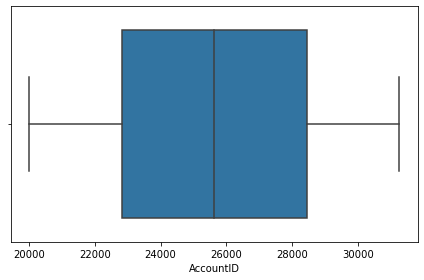

After Removing Outliers


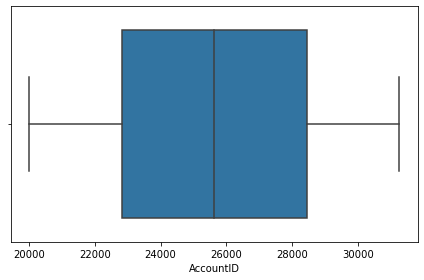

Before Removing Outliers


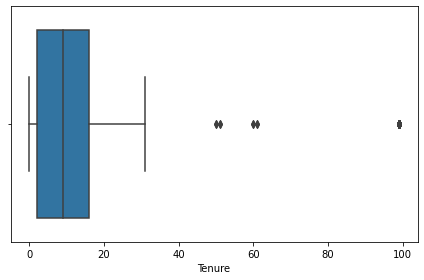

After Removing Outliers


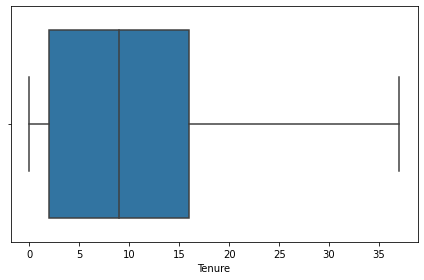

Before Removing Outliers


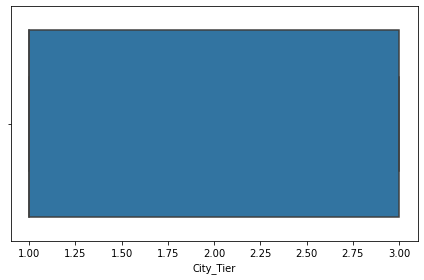

After Removing Outliers


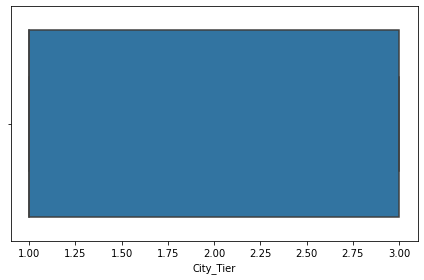

Before Removing Outliers


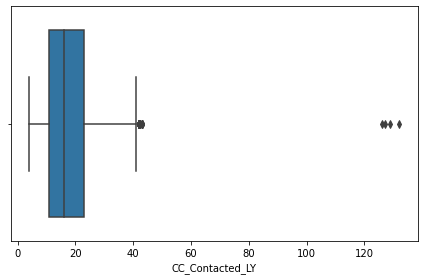

After Removing Outliers


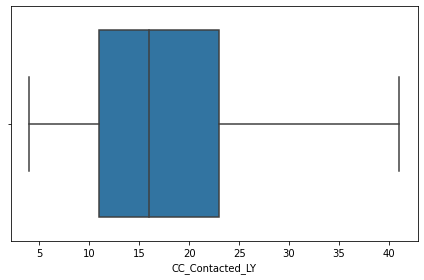

Before Removing Outliers


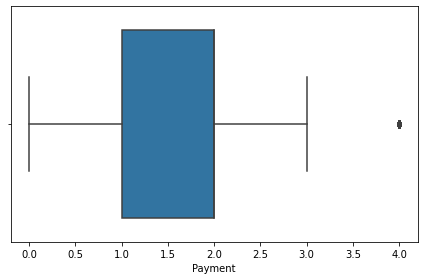

After Removing Outliers


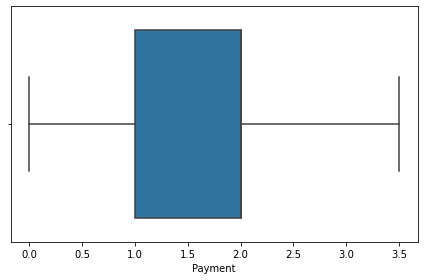

Before Removing Outliers


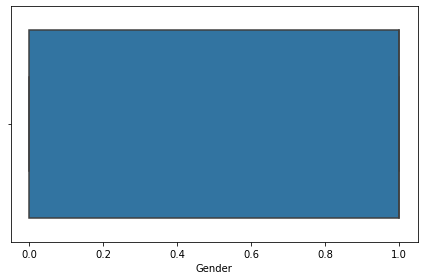

After Removing Outliers


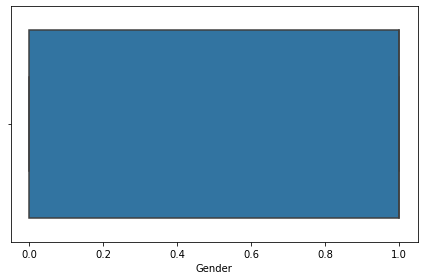

Before Removing Outliers


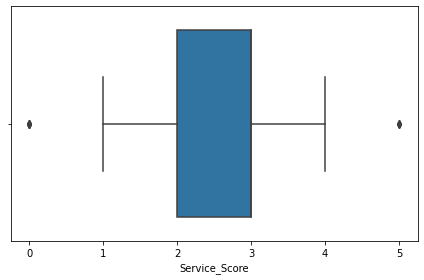

After Removing Outliers


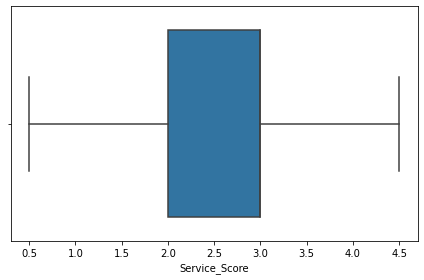

Before Removing Outliers


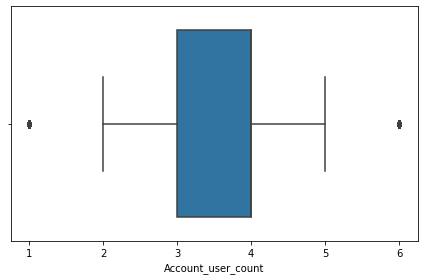

After Removing Outliers


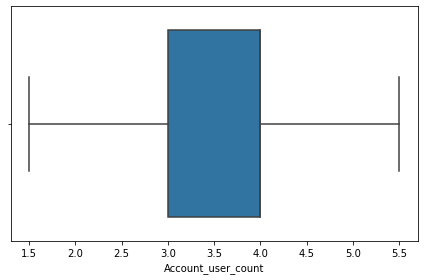

Before Removing Outliers


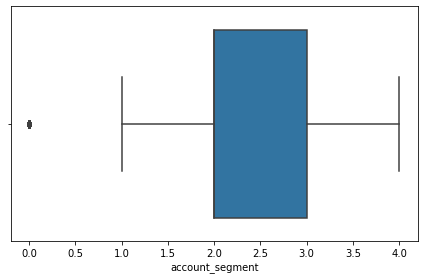

After Removing Outliers


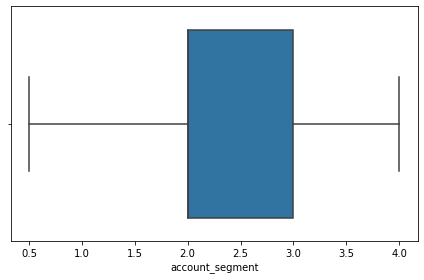

Before Removing Outliers


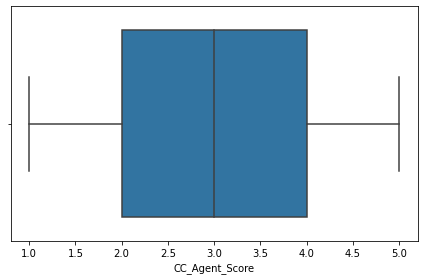

After Removing Outliers


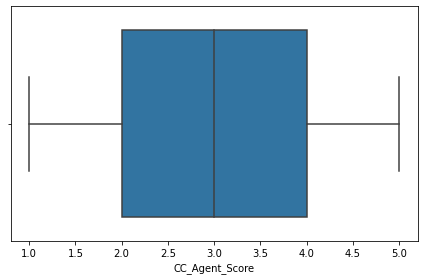

Before Removing Outliers


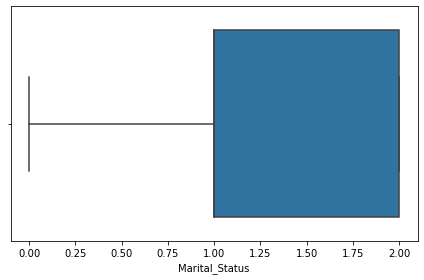

After Removing Outliers


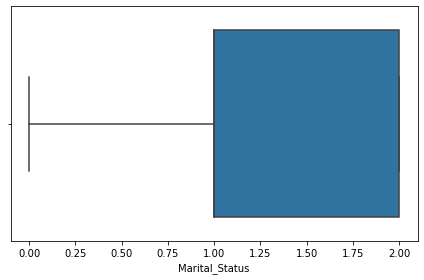

Before Removing Outliers


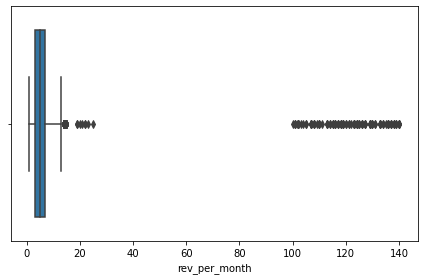

After Removing Outliers


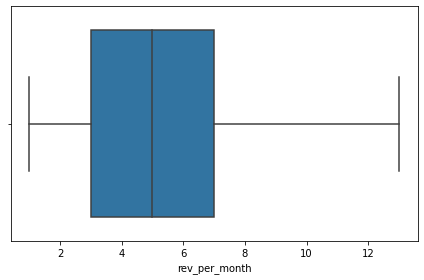

Before Removing Outliers


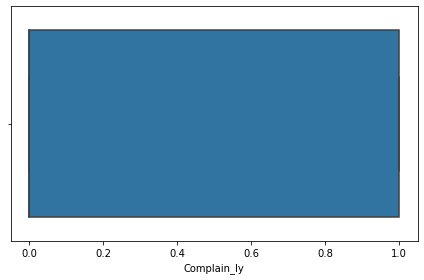

After Removing Outliers


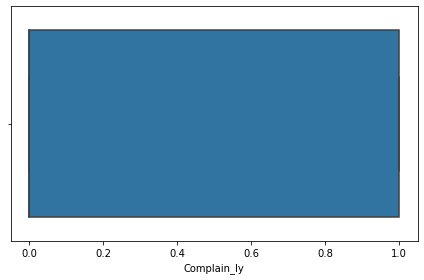

Before Removing Outliers


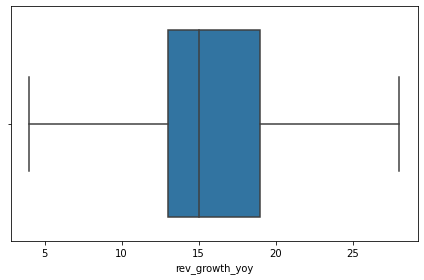

After Removing Outliers


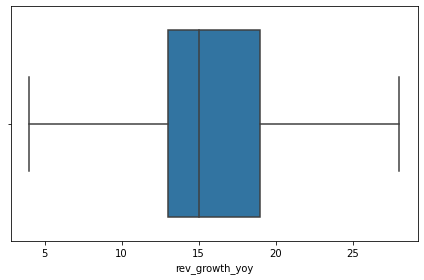

Before Removing Outliers


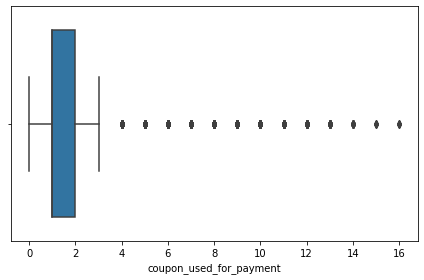

After Removing Outliers


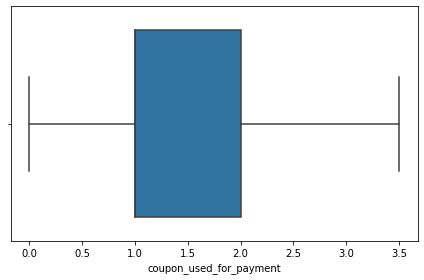

Before Removing Outliers


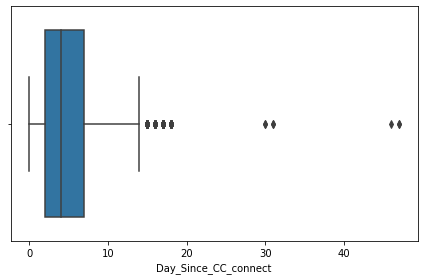

After Removing Outliers


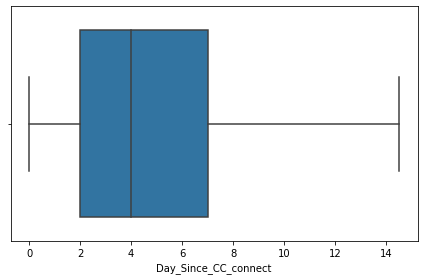

Before Removing Outliers


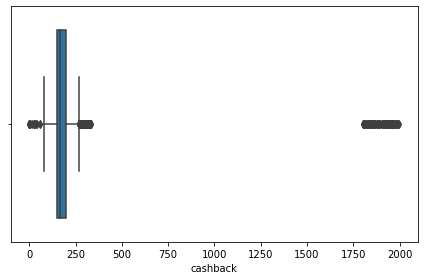

After Removing Outliers


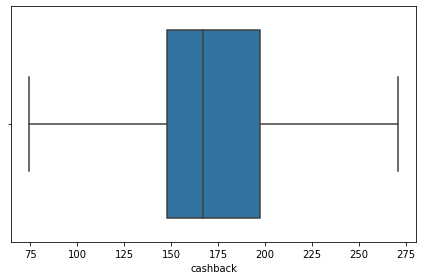

Before Removing Outliers


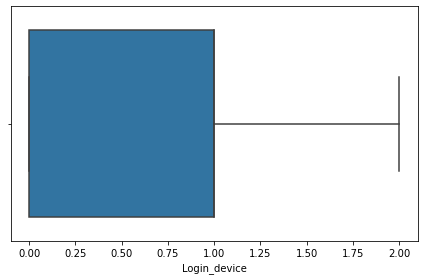

After Removing Outliers


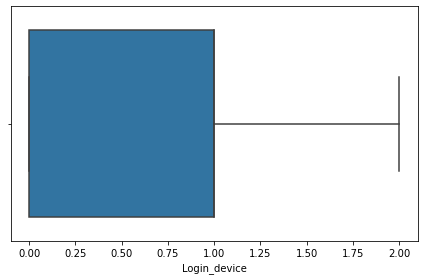

Before Removing Outliers


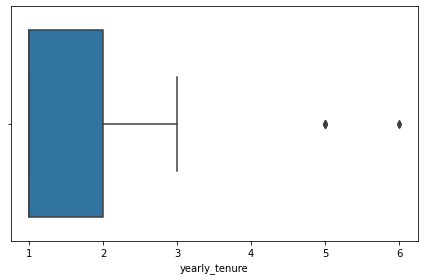

After Removing Outliers


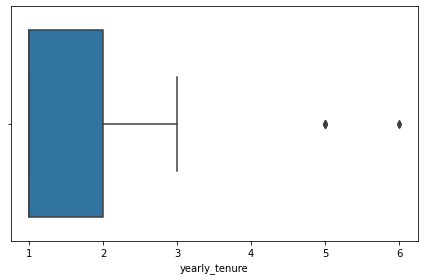

In [113]:
df1=remove_outliers(df1)

In [114]:
df.shape
df

,AccountID,Churn,Tenure,City_Tier,CC_Contacted_LY,Payment,Gender,Service_Score,Account_user_count,account_segment,CC_Agent_Score,Marital_Status,rev_per_month,Complain_ly,rev_growth_yoy,coupon_used_for_payment,Day_Since_CC_connect,cashback,Login_device,yearly_tenure
0,20000,1,4.0,3.0,6.0,2,0,3.0,3.0,3,2.0,2,9.0,1.0,11.0,1.0,5.0,160.0,1,1.0
1,20001,1,0.0,1.0,8.0,4,1,3.0,4.0,2,3.0,2,7.0,1.0,15.0,0.0,0.0,121.0,1,1.0
2,20002,1,0.0,1.0,30.0,2,1,2.0,4.0,2,3.0,2,6.0,1.0,14.0,0.0,3.0,196.0,1,1.0
3,20003,1,0.0,3.0,15.0,2,1,2.0,4.0,3,5.0,2,8.0,0.0,23.0,0.0,3.0,134.0,1,1.0
4,20004,1,0.0,1.0,12.0,1,1,2.0,3.0,2,5.0,2,3.0,0.0,11.0,1.0,3.0,130.0,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11255,31255,0,10.0,1.0,34.0,1,1,3.0,2.0,3,1.0,1,9.0,0.0,19.0,1.0,4.0,154.0,0,1.0
11256,31256,0,13.0,1.0,19.0,1,1,3.0,5.0,0,5.0,1,7.0,0.0,16.0,1.0,8.0,227.0,1,2.0
11257,31257,0,1.0,1.0,14.0,2,1,3.0,2.0,3,4.0,1,7.0,1.0,22.0,1.0,4.0,191.0,1,1.0
11258,31258,0,23.0,3.0,11.0,1,1,4.0,5.0,3,4.0,1,7.0,0.0,16.0,2.0,9.0,180.0,0,2.0


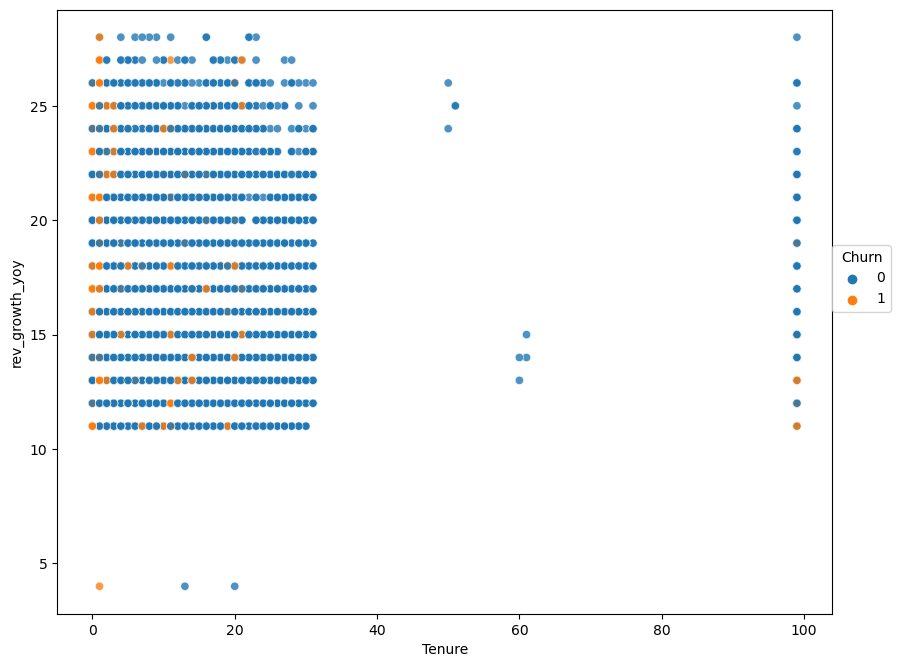

In [115]:
plt.figure(figsize=(10,8),dpi=100)
sns.scatterplot(data=df,x='Tenure',y='rev_growth_yoy',hue='Churn',alpha=0.8)
plt.legend(loc=(1,0.5),title = "Churn")

In [116]:
no_churn = df.groupby(['Churn','Tenure']).count().transpose()[0]
yes_churn = df.groupby(['Churn','Tenure']).count().transpose()[1]

<AxesSubplot:xlabel='Tenure', ylabel='Rate Customers Choose to Churn(%)'>

<Figure size 720x360 with 0 Axes>

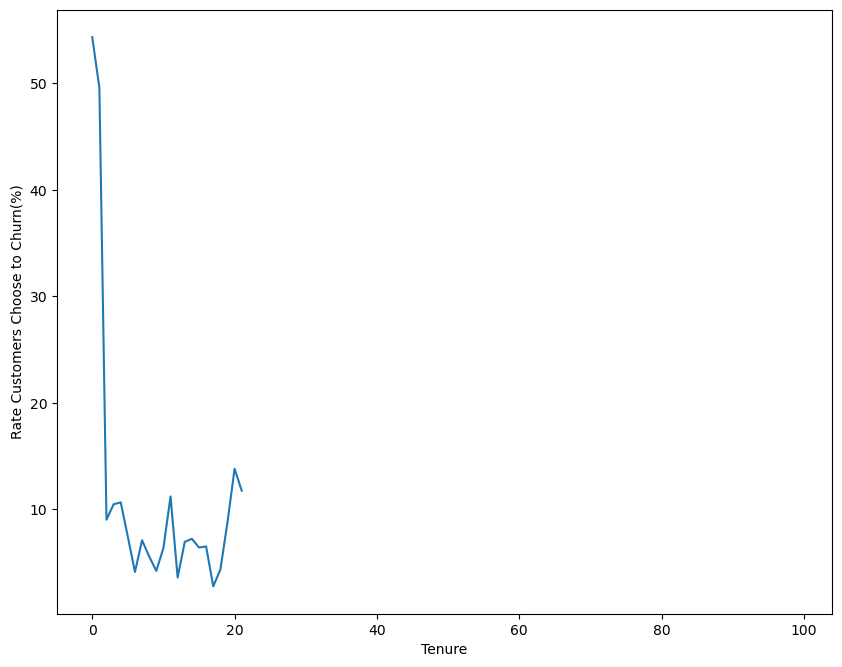

In [117]:
plt.figure(figsize=(10,5))
churn_rates_Yes = 100 * yes_churn/(no_churn+yes_churn)
plt.figure(figsize=(10,8),dpi=100)
plt.ylabel('Rate Customers Choose to Churn(%)')
churn_rates_Yes.iloc[0].plot()

In [118]:
df_corr=dataset2.corr()

In [119]:
df['Tenure'].describe()

count    11260.000000
mean        11.024600
std         12.754482
min          0.000000
25%          2.000000
50%          9.000000
75%         16.000000
max         99.000000
Name: Tenure, dtype: float64

In [120]:
def yearly_tenure(tenure):
    if tenure <= 12:
        return 1
    elif tenure >12 and tenure <=24:
        return 2
    elif tenure >24 and tenure <=36:
        return 3
    elif tenure >36 and tenure <=48:
        return 4
    elif tenure >48 and tenure <=60:
        return 5
    elif tenure > 60 and tenure <=72:
        return 6

In [121]:
df['yearly_tenure'] = df['Tenure'].apply(yearly_tenure)

In [122]:
df.head()

,AccountID,Churn,Tenure,City_Tier,CC_Contacted_LY,Payment,Gender,Service_Score,Account_user_count,account_segment,CC_Agent_Score,Marital_Status,rev_per_month,Complain_ly,rev_growth_yoy,coupon_used_for_payment,Day_Since_CC_connect,cashback,Login_device,yearly_tenure
0,20000,1,4.0,3.0,6.0,2,0,3.0,3.0,3,2.0,2,9.0,1.0,11.0,1.0,5.0,160.0,1,1.0
1,20001,1,0.0,1.0,8.0,4,1,3.0,4.0,2,3.0,2,7.0,1.0,15.0,0.0,0.0,121.0,1,1.0
2,20002,1,0.0,1.0,30.0,2,1,2.0,4.0,2,3.0,2,6.0,1.0,14.0,0.0,3.0,196.0,1,1.0
3,20003,1,0.0,3.0,15.0,2,1,2.0,4.0,3,5.0,2,8.0,0.0,23.0,0.0,3.0,134.0,1,1.0
4,20004,1,0.0,1.0,12.0,1,1,2.0,3.0,2,5.0,2,3.0,0.0,11.0,1.0,3.0,130.0,1,1.0


## All variables with churn rate

Text(0.5, 0, 'Tenure in years')

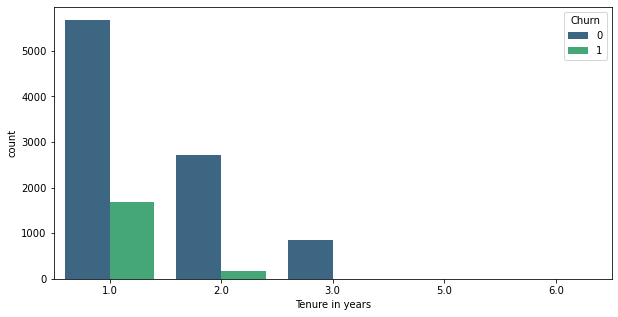

In [123]:
plt.figure(figsize=(10,5))
sns.countplot(data=df,x='yearly_tenure',hue='Churn',palette='viridis')
plt.xlabel('Tenure in years')

Text(0.5, 0, 'Tenure in years')

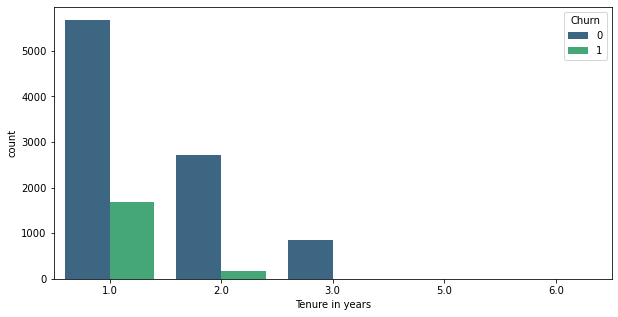

In [124]:
plt.figure(figsize=(10,5))
sns.countplot(data=df,x='yearly_tenure',hue='Churn',palette='viridis')
plt.xlabel('Tenure in years')

In [125]:
df1['rev_per_month'].describe()

count    11260.000000
mean         5.321048
std          2.884834
min          1.000000
25%          3.000000
50%          5.000000
75%          7.000000
max         13.000000
Name: rev_per_month, dtype: float64

In [126]:
from sklearn.model_selection import train_test_split

In [127]:
cols_to_scale =df1.columns

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df1[cols_to_scale] = scaler.fit_transform(df1[cols_to_scale])

In [128]:
df1.head()

,AccountID,Tenure,City_Tier,CC_Contacted_LY,Payment,Gender,Service_Score,Account_user_count,account_segment,CC_Agent_Score,Marital_Status,rev_per_month,Complain_ly,rev_growth_yoy,coupon_used_for_payment,Day_Since_CC_connect,cashback,Login_device,yearly_tenure
0,0.000000,0.108108,1.0,0.054054,0.571429,0.0,0.625,0.375,0.714286,0.25,1.0,0.666667,1.0,0.291667,0.285714,0.344828,0.436224,0.5,0.0
1,0.000089,0.000000,0.0,0.108108,1.000000,1.0,0.625,0.625,0.428571,0.50,1.0,0.500000,1.0,0.458333,0.000000,0.000000,0.237245,0.5,0.0
2,0.000178,0.000000,0.0,0.702703,0.571429,1.0,0.375,0.625,0.428571,0.50,1.0,0.416667,1.0,0.416667,0.000000,0.206897,0.619898,0.5,0.0
3,0.000266,0.000000,1.0,0.297297,0.571429,1.0,0.375,0.625,0.714286,1.00,1.0,0.583333,0.0,0.791667,0.000000,0.206897,0.303571,0.5,0.0
4,0.000355,0.000000,0.0,0.216216,0.285714,1.0,0.375,0.375,0.428571,1.00,1.0,0.166667,0.0,0.291667,0.285714,0.206897,0.283163,0.5,0.0


In [131]:
for col in df1:
    print(f'{col}: {df1[col].unique()}')

AccountID: [0.00000000e+00 8.88178346e-05 1.77635669e-04 ... 9.99822364e-01
 9.99911182e-01 1.00000000e+00]
Tenure: [0.10810811 0.         0.05405405 0.35135135 0.2972973  0.24324324
 1.         0.51351351 0.54054054 0.37837838 0.21621622 0.7027027
 0.48648649 0.13513514 0.81081081 0.18918919 0.02702703 0.62162162
 0.08108108 0.78378378 0.16216216 0.75675676 0.64864865 0.67567568
 0.43243243 0.27027027 0.40540541 0.59459459 0.72972973 0.32432432
 0.56756757 0.45945946 0.83783784]
City_Tier: [1.  0.  0.5]
CC_Contacted_LY: [0.05405405 0.10810811 0.7027027  0.2972973  0.21621622 0.48648649
 0.18918919 0.13513514 0.72972973 0.37837838 0.24324324 0.43243243
 0.67567568 0.64864865 0.59459459 0.27027027 0.16216216 0.56756757
 0.62162162 0.35135135 0.51351351 0.78378378 0.40540541 0.83783784
 0.54054054 0.32432432 0.75675676 0.45945946 0.81081081 0.02702703
 0.         1.         0.08108108 0.86486486 0.91891892 0.89189189
 0.94594595 0.97297297]
Payment: [0.57142857 1.         0.28571429 0.  

In [135]:
X= pd.get_dummies(df1.drop(['AccountID'],axis=1),drop_first=True)
y= df['Churn']

In [137]:
X[:10]

,Tenure,City_Tier,CC_Contacted_LY,Payment,Gender,Service_Score,Account_user_count,account_segment,CC_Agent_Score,Marital_Status,rev_per_month,Complain_ly,rev_growth_yoy,coupon_used_for_payment,Day_Since_CC_connect,cashback,Login_device,yearly_tenure
0,0.108108,1.0,0.054054,0.571429,0.0,0.625,0.375,0.714286,0.25,1.0,0.666667,1.0,0.291667,0.285714,0.344828,0.436224,0.5,0.0
1,0.000000,0.0,0.108108,1.000000,1.0,0.625,0.625,0.428571,0.50,1.0,0.500000,1.0,0.458333,0.000000,0.000000,0.237245,0.5,0.0
2,0.000000,0.0,0.702703,0.571429,1.0,0.375,0.625,0.428571,0.50,1.0,0.416667,1.0,0.416667,0.000000,0.206897,0.619898,0.5,0.0
3,0.000000,1.0,0.297297,0.571429,1.0,0.375,0.625,0.714286,1.00,1.0,0.583333,0.0,0.791667,0.000000,0.206897,0.303571,0.5,0.0
4,0.000000,0.0,0.216216,0.285714,1.0,0.375,0.375,0.428571,1.00,1.0,0.166667,0.0,0.291667,0.285714,0.206897,0.283163,0.5,0.0
5,0.000000,0.0,0.486486,0.571429,0.0,0.625,0.625,0.428571,1.00,1.0,0.083333,1.0,0.750000,1.000000,0.482759,0.329082,0.0,0.0
6,0.054054,1.0,0.189189,0.000000,1.0,0.375,0.375,0.714286,0.25,0.0,0.250000,0.0,0.416667,0.000000,0.000000,0.237245,0.5,0.0
7,0.000000,0.0,0.054054,0.285714,1.0,0.625,0.375,0.428571,0.25,0.0,0.166667,1.0,0.500000,0.571429,0.000000,0.247449,0.5,0.0
8,0.351351,1.0,0.135135,0.857143,1.0,0.375,0.625,0.428571,0.50,0.0,0.083333,1.0,0.416667,0.000000,0.137931,0.267857,0.5,0.2
9,0.000000,0.0,0.729730,0.571429,1.0,0.375,0.875,0.428571,0.50,1.0,0.083333,0.0,0.333333,0.285714,0.068966,0.247449,0.5,0.0


In [141]:
X_train.shape

(8445, 18)

In [145]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=20)

In [139]:
from sklearn.preprocessing import StandardScaler

In [102]:
scaler= StandardScaler()

In [105]:
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

In [146]:
len(X_train.columns)

18

In [150]:
import tensorflow as tf
from tensorflow import keras


model = keras.Sequential([
    keras.layers.Dense(18, input_shape=(18,), activation='relu'),
    keras.layers.Dense(15, activation='relu'),
    keras.layers.Dense(5, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

# opt = keras.optimizers.Adam(learning_rate=0.01)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=100)

Epoch 1/100


ValueError: in user code:

    C:\Users\vedpr\.conda\envs\Developer\lib\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    C:\Users\vedpr\.conda\envs\Developer\lib\site-packages\tensorflow\python\keras\engine\training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\vedpr\.conda\envs\Developer\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\vedpr\.conda\envs\Developer\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\vedpr\.conda\envs\Developer\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\vedpr\.conda\envs\Developer\lib\site-packages\tensorflow\python\keras\engine\training.py:789 run_step  **
        outputs = model.train_step(data)
    C:\Users\vedpr\.conda\envs\Developer\lib\site-packages\tensorflow\python\keras\engine\training.py:748 train_step
        loss = self.compiled_loss(
    C:\Users\vedpr\.conda\envs\Developer\lib\site-packages\tensorflow\python\keras\engine\compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    C:\Users\vedpr\.conda\envs\Developer\lib\site-packages\tensorflow\python\keras\losses.py:149 __call__
        losses = ag_call(y_true, y_pred)
    C:\Users\vedpr\.conda\envs\Developer\lib\site-packages\tensorflow\python\keras\losses.py:253 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    C:\Users\vedpr\.conda\envs\Developer\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    C:\Users\vedpr\.conda\envs\Developer\lib\site-packages\tensorflow\python\keras\losses.py:1605 binary_crossentropy
        K.binary_crossentropy(y_true, y_pred, from_logits=from_logits), axis=-1)
    C:\Users\vedpr\.conda\envs\Developer\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    C:\Users\vedpr\.conda\envs\Developer\lib\site-packages\tensorflow\python\keras\backend.py:4823 binary_crossentropy
        return nn.sigmoid_cross_entropy_with_logits(labels=target, logits=output)
    C:\Users\vedpr\.conda\envs\Developer\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    C:\Users\vedpr\.conda\envs\Developer\lib\site-packages\tensorflow\python\ops\nn_impl.py:173 sigmoid_cross_entropy_with_logits
        raise ValueError("logits and labels must have the same shape (%s vs %s)" %

    ValueError: logits and labels must have the same shape ((None, 2) vs (None, 1))


In [109]:
scaled_X_train.shape

(14046, 17)

In [110]:
scaled_X_train[:10]

array([[ 2.14164677, -0.80266609, -1.44166102, -0.78879316, -1.12868037,
        -1.33683768,  0.22917016,  2.06156301, -0.15312458, -0.23574531,
         0.21243683,  1.36832031,  1.03443486, -1.3769738 , -0.63638256,
         1.37433501,  2.49999743],
       [ 0.74454274,  0.31151685, -0.85765858, -0.78879316, -1.12868037,
         0.12428579, -2.02120933,  0.9391201 ,  0.61378245, -1.69897049,
         0.56745148, -0.81156633,  2.64106587, -0.42904745,  1.15640243,
        -0.13803789, -1.33079555],
       [ 0.04599072,  1.42569978, -0.6240576 ,  0.29144961, -1.12868037,
        -1.33683768, -0.89601958,  0.9391201 , -1.68693862, -0.23574531,
        -1.20762176,  1.36832031, -1.37551166, -0.42904745,  1.45519993,
        -0.49812668,  0.58460094],
       [ 0.97739341,  1.42569978,  0.89434874,  0.29144961,  0.88599042,
        -1.33683768,  0.22917016,  0.9391201 , -0.9200316 , -1.69897049,
        -0.49759246, -0.81156633,  0.49889119, -1.3769738 , -0.63638256,
         0.05400946

In [104]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier()
param_grid= {'n_neighbors':range(1,50), 'metric': ['minkowski','manhattan','euclidean']}
knn_grid_model = GridSearchCV(knn_model,param_grid,cv=10, scoring='accuracy', return_train_score=False,verbose=1)
knn_grid_model.fit(scaled_X_train,y_train)

Fitting 10 folds for each of 147 candidates, totalling 1470 fits


KeyboardInterrupt: 

In [104]:
print(knn_grid_model.best_params_)

{'metric': 'manhattan', 'n_neighbors': 1}


In [105]:
accuracy = knn_grid_model.best_score_ *100
print("Accuracy for our training dataset with tuning is : {:.2f}%".format(accuracy) )

Accuracy for our training dataset with tuning is : 99.11%


In [106]:
knn = KNeighborsClassifier(n_neighbors=1,metric='manhattan')
knn_grid_model = GridSearchCV(knn,param_grid,cv=10, scoring='accuracy', return_train_score=False,verbose=1)

In [107]:
svc = SVC()
param_grid_svm={'C': [0.1,0.5,1,2,10],'gamma':['scale','auto'],'kernel': ['linear','rbf','poly','sigmoid']}
svc_grid_model= GridSearchCV(svc,param_grid_svm,cv=5)

In [108]:
from sklearn.ensemble import GradientBoostingClassifier
gbmodel= GradientBoostingClassifier()
gb_param_grid= {'n_estimators':[50,100],'learning_rate':[0.1,0.05,0.2],'max_depth':[3,4,5]}

In [109]:

from sklearn.ensemble import AdaBoostClassifier
Ada_model= AdaBoostClassifier()
param_grid_Ada= {'n_estimators':range(1,50)}

In [110]:
error_rates= []
for n in range(1,100):
    model = AdaBoostClassifier(n_estimators=n)
    model.fit(X_train,y_train)
    
    predict= model.predict(X_test)
    
    error= 1- accuracy_score(y_test,predict)
    
    error_rates.append(error)

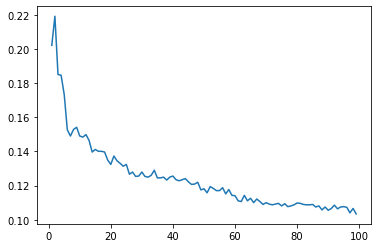

In [111]:
plt.plot(range(1,100),error_rates)

In [112]:
Ada_model_final = AdaBoostClassifier(n_estimators=20)

In [113]:
from sklearn.ensemble import RandomForestClassifier


In [114]:
error_rates= []
for n in range(1,100):
    model = RandomForestClassifier(n_estimators=n)
    model.fit(X_train,y_train)
    
    predict= model.predict(X_test)
    
    error= 1- accuracy_score(y_test,predict)
    
    error_rates.append(error)

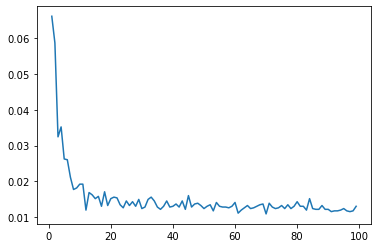

In [115]:
plt.plot(range(1,100),error_rates)

In [116]:
for_reg = RandomForestClassifier(random_state = 65)

In [117]:
error_rates= []
for n in range(1,100):
    model = DecisionTreeClassifier(criterion='entropy',max_depth=n)
    model.fit(X_train,y_train)
    
    predict= model.predict(X_test)
    
    error= 1- accuracy_score(y_test,predict)
    
    error_rates.append(error)

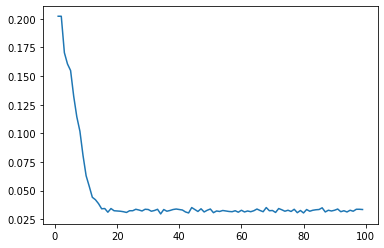

In [118]:
plt.plot(range(1,100),error_rates)

In [119]:
DTC=DecisionTreeClassifier(criterion='entropy',max_depth=19)

In [120]:
lr = linear_model.LogisticRegression()

In [121]:
models=[knn_grid_model,Ada_model_final,for_reg,DTC,lr]

Fitting 10 folds for each of 147 candidates, totalling 1470 fits
GridSearchCV(cv=10,
             estimator=KNeighborsClassifier(metric='manhattan', n_neighbors=1),
             param_grid={'metric': ['minkowski', 'manhattan', 'euclidean'],
                         'n_neighbors': range(1, 50)},
             scoring='accuracy', verbose=1)
Accuracy for our training dataset with tuning is : 0.99%
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2368
           1       0.99      1.00      0.99      2314

    accuracy                           0.99      4682
   macro avg       0.99      0.99      0.99      4682
weighted avg       0.99      0.99      0.99      4682

AdaBoostClassifier(n_estimators=20)
Accuracy for our training dataset with tuning is : 0.87%
              precision    recall  f1-score   support

           0       0.87      0.86      0.87      2368
           1       0.86      0.87      0.87      2314

    accuracy       

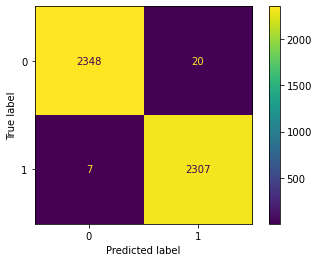

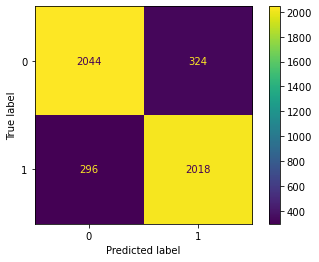

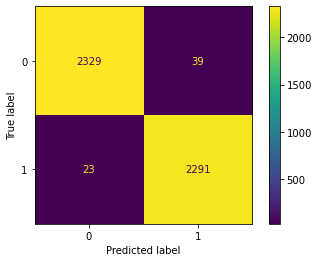

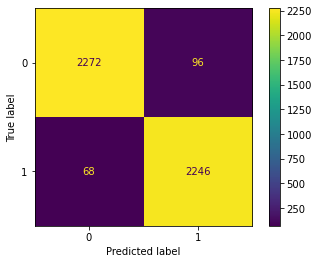

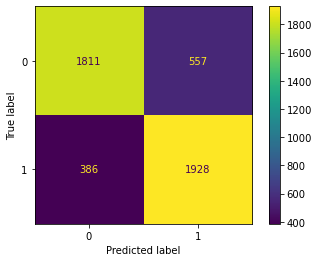

In [122]:
accuracy=[]
max_acc=0
for model in models:
    model.fit(scaled_X_train,y_train)
    y_test_pred=model.predict(scaled_X_test)
    acc=accuracy_score(y_test,y_test_pred)
    print(model)
    print("Accuracy for our training dataset with tuning is : {:.2f}%".format(acc) )
    print(classification_report(y_test,y_test_pred))
    plot_confusion_matrix(model,scaled_X_test,y_test)
    ax.set_title(str(model)); 

In [123]:
features= pd.DataFrame(index= X.columns,data=for_reg.feature_importances_,columns=['Importance'])

Text(0.5, 1.0, 'Random Forest Feature Importance')

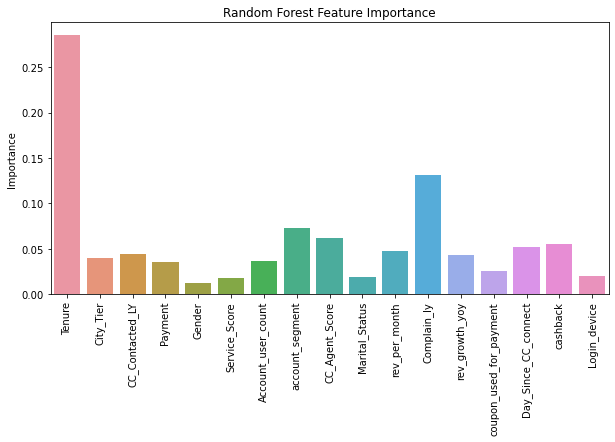

In [124]:
plt.figure(figsize=(10,5))
plt.xticks(rotation=90)
sns.barplot(data=features,x=features.index,y='Importance')
plt.title("Random Forest Feature Importance")

In [125]:
features1= pd.DataFrame(index= X.columns,data=Ada_model_final.feature_importances_,columns=['Importance'])

Text(0.5, 1.0, 'Ada Boost Feature Importance')

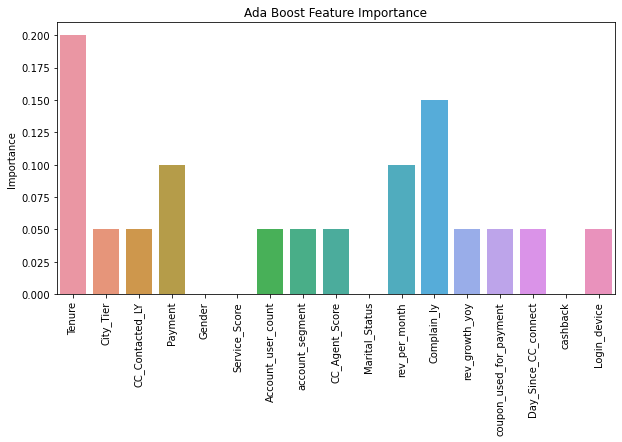

In [126]:
plt.figure(figsize=(10,5))
plt.xticks(rotation=90)
sns.barplot(data=features1,x=features1.index,y='Importance')
plt.title("Ada Boost Feature Importance")

In [127]:
mse = mean_squared_error(predict.round(),y_test)

In [128]:
rmse = np.sqrt(mse)
rmse

0.18311930084671205

In [129]:
pred_probknn = knn_grid_model.predict_proba(scaled_X_test)

In [130]:
pred_problr=lr.predict_proba(scaled_X_test)
pred_probafc=Ada_model_final.predict_proba(scaled_X_test)
pred_probrfc=for_reg.predict_proba(scaled_X_test)


In [131]:
from sklearn.metrics import roc_curve

# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_test, pred_probknn[:,1], pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_test, pred_problr[:,1], pos_label=1)
fpr3, tpr3, thresh3 = roc_curve(y_test, pred_probafc[:,1], pos_label=1)
fpr4, tpr4, thresh4 = roc_curve(y_test, pred_probrfc[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

In [132]:
from sklearn.metrics import roc_auc_score

# auc scores
auc_scoreknn = roc_auc_score(y_test, pred_probknn[:,1])
auc_scorelr = roc_auc_score(y_test, pred_problr[:,1])
auc_scoreafc = roc_auc_score(y_test, pred_probafc[:,1])
auc_scorerfc = roc_auc_score(y_test, pred_problr[:,1])

print(auc_scoreknn, auc_scorelr,auc_scoreafc, auc_scorerfc)

0.9942644946156182 0.8741318633348127 0.9351917821018945 0.8741318633348127


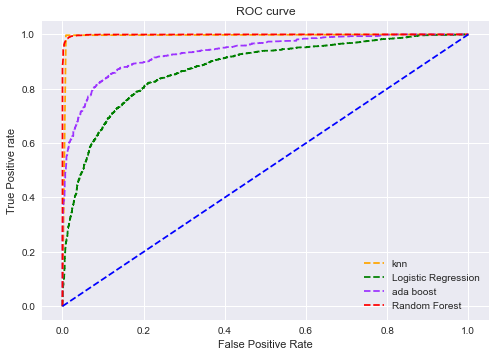

In [133]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='knn')
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='Logistic Regression')
plt.plot(fpr3, tpr3, linestyle='--',color='#9C33FF', label='ada boost') #violet
plt.plot(fpr4, tpr4, linestyle='--',color='red', label='Random Forest') #red
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();